This is based on https://bambinos.github.io/bambi/main/notebooks/model_comparison.html?highlight=product

# Adults dataset

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from scipy.special import expit as invlogit

# Disable a FutureWarning in ArviZ at the moment of running the notebook
az.style.use("arviz-darkgrid")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = bmb.load_data("adults")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   income   32561 non-null  object
 1   sex      32561 non-null  object
 2   race     32561 non-null  object
 3   age      32561 non-null  int64 
 4   hs_week  32561 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


,income,sex,race,age,hs_week
0,<=50K,Male,White,39,40
1,<=50K,Male,White,50,13
2,<=50K,Male,White,38,40
3,<=50K,Male,Black,53,40
4,<=50K,Female,Black,28,40


In [3]:
categorical_cols = data.columns[data.dtypes == object].tolist()
for col in categorical_cols:
    data[col] = data[col].astype("category")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   income   32561 non-null  category
 1   sex      32561 non-null  category
 2   race     32561 non-null  category
 3   age      32561 non-null  int64   
 4   hs_week  32561 non-null  int64   
dtypes: category(3), int64(2)
memory usage: 604.7 KB


# EDA

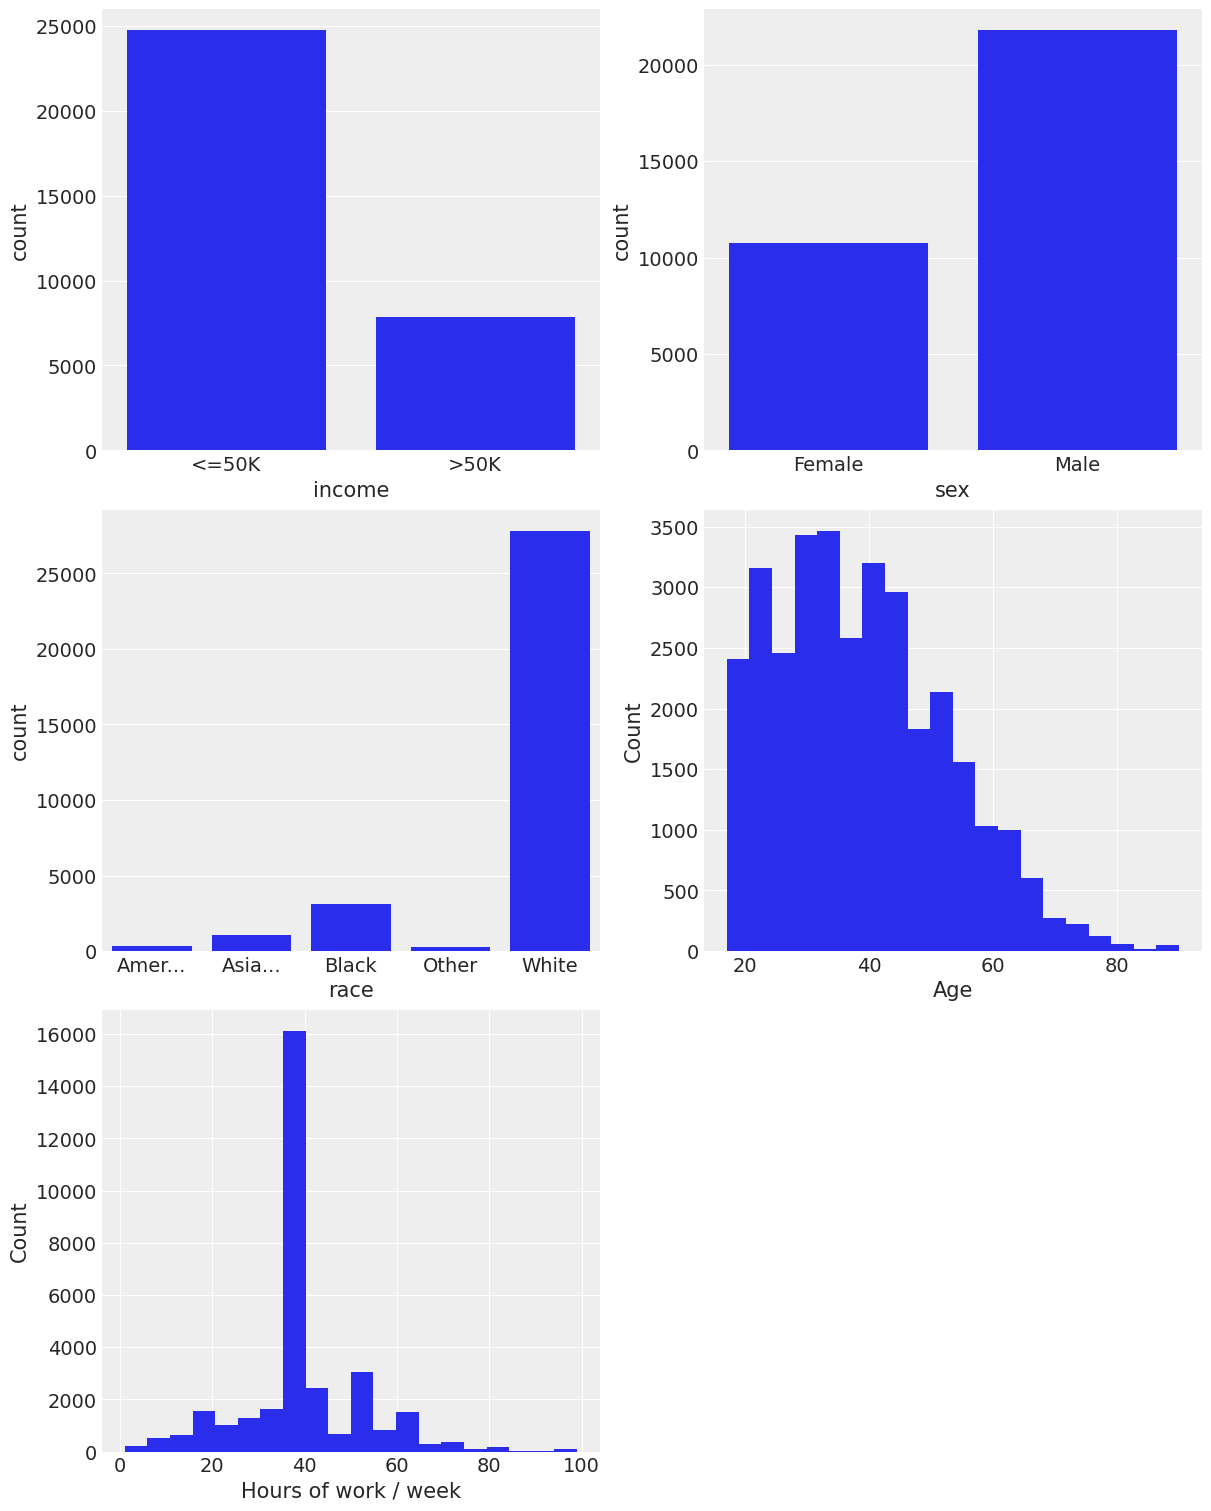

In [4]:
# Just a utilitary function to truncate labels and avoid overlapping in plots
def truncate_labels(ticklabels, width=8):
    def truncate(label, width):
        if len(label) > width - 3:
            return label[0 : (width - 4)] + "..."
        else:
            return label

    labels = [x.get_text() for x in ticklabels]
    labels = [truncate(lbl, width) for lbl in labels]

    return labels

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
sns.countplot(x="income", color="C0", data=data, ax=axes[0, 0], saturation=1)
sns.countplot(x="sex", color="C0", data=data, ax=axes[0, 1], saturation=1);
sns.countplot(x="race", color="C0", data=data, ax=axes[1, 0], saturation=1);
axes[1, 0].set_xticklabels(truncate_labels(axes[1, 0].get_xticklabels()))
axes[1, 1].hist(data["age"], bins=20);
axes[1, 1].set_xlabel("Age")
axes[1, 1].set_ylabel("Count")
axes[2, 0].hist(data["hs_week"], bins=20);
axes[2, 0].set_xlabel("Hours of work / week")
axes[2, 0].set_ylabel("Count")
axes[2, 1].axis('off');

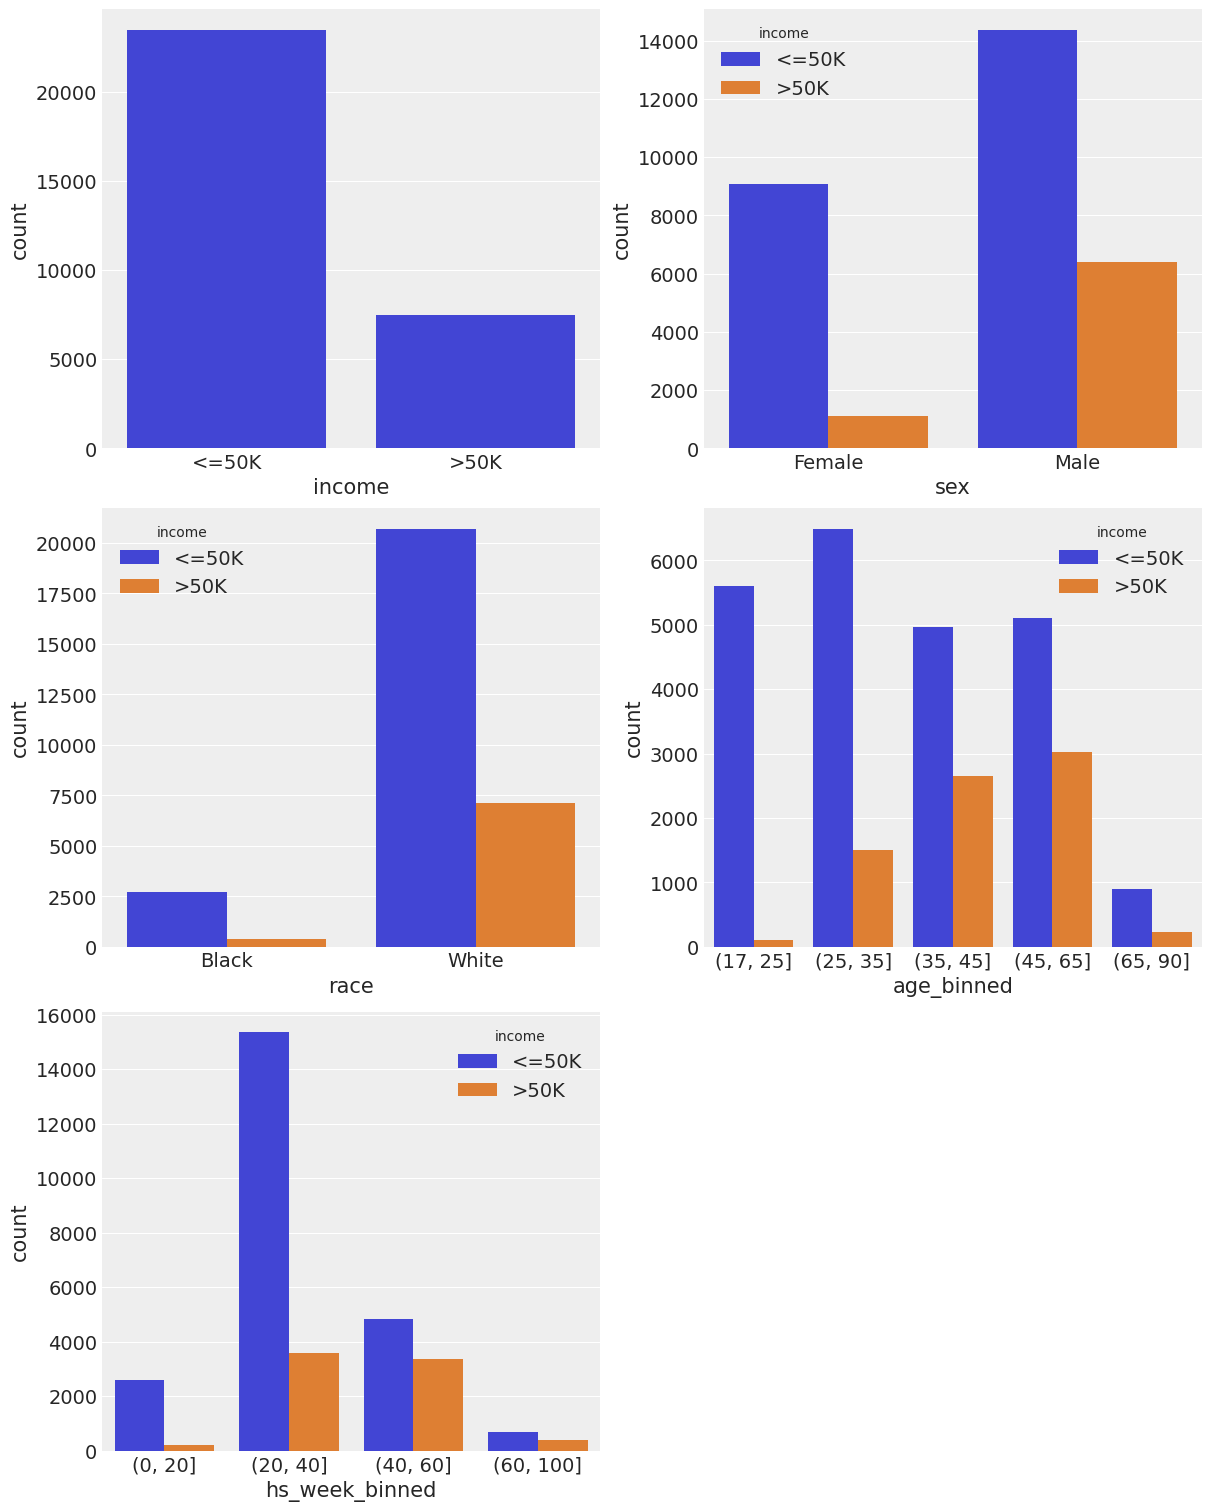

In [5]:
data = data[data["race"].isin(["Black", "White"])]
data["race"] = data["race"].cat.remove_unused_categories()
age_bins = [17, 25, 35, 45, 65, 90]
data["age_binned"] = pd.cut(data["age"], age_bins)
hours_bins = [0, 20, 40, 60, 100]
data["hs_week_binned"] = pd.cut(data["hs_week"], hours_bins)

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
sns.countplot(x="income", color="C0", data=data, ax=axes[0, 0])
sns.countplot(x="sex", hue="income", data=data, ax=axes[0, 1])
sns.countplot(x="race", hue="income", data=data, ax=axes[1, 0])
sns.countplot(x="age_binned", hue="income", data=data, ax=axes[1, 1])
sns.countplot(x="hs_week_binned", hue="income", data=data, ax=axes[2, 0])
axes[2, 1].axis("off");

In [6]:
age_mean = np.mean(data["age"])
age_std = np.std(data["age"])
hs_mean = np.mean(data["hs_week"])
hs_std = np.std(data["hs_week"])

data["age"] = (data["age"] - age_mean) / age_std
data["age2"] = data["age"] ** 2
data["age3"] = data["age"] ** 3
data["hs_week"] = (data["hs_week"] - hs_mean) / hs_std
data["hs_week2"] = data["hs_week"] ** 2
data["hs_week3"] = data["hs_week"] ** 3

data = data.drop(columns=["age_binned", "hs_week_binned"])

data.head()

,income,sex,race,age,hs_week,age2,age3,hs_week2,hs_week3
0,<=50K,Male,White,0.024207,-0.037250,0.000586,0.000014,0.001388,-0.000052
1,<=50K,Male,White,0.827984,-2.222326,0.685557,0.567630,4.938734,-10.975479
2,<=50K,Male,White,-0.048863,-0.037250,0.002388,-0.000117,0.001388,-0.000052
3,<=50K,Male,Black,1.047195,-0.037250,1.096618,1.148374,0.001388,-0.000052
4,<=50K,Female,Black,-0.779569,-0.037250,0.607728,-0.473766,0.001388,-0.000052


# Model

## Model 1

In [7]:
model1 = bmb.Model("income['>50K'] ~ sex + race + age + hs_week", data, family="bernoulli")
fitted1 = model1.fit(draws=1000)

Modeling the probability that income==>50K
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sex, race, age, hs_week]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.636,0.064,-2.757,-2.524,0.001,0.001,4511.0,3193.0,1.0
sex[Male],1.019,0.037,0.953,1.090,0.001,0.000,4690.0,3314.0,1.0
race[White],0.631,0.060,0.515,0.739,0.001,0.001,5002.0,3375.0,1.0
age,0.579,0.015,0.550,0.607,0.000,0.000,5159.0,3590.0,1.0
hs_week,0.504,0.015,0.476,0.532,0.000,0.000,4689.0,3001.0,1.0


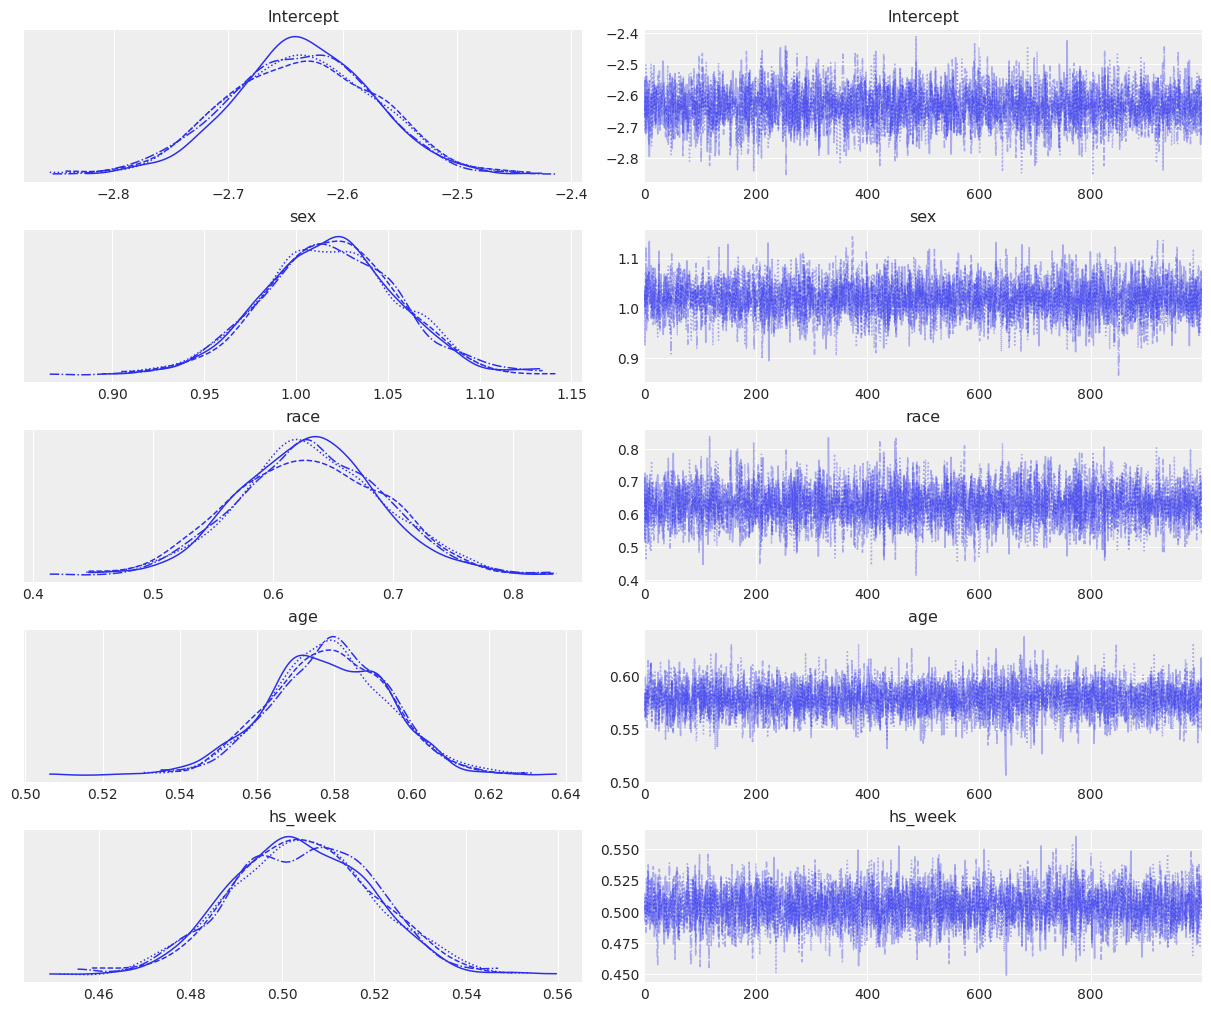

In [8]:
az.plot_trace(fitted1);
az.summary(fitted1)

## Model 2

In [9]:
model2 = bmb.Model("income['>50K'] ~ sex + race + age + age2 + hs_week + hs_week2", data, family="bernoulli")
fitted2 = model2.fit()

Modeling the probability that income==>50K
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sex, race, age, age2, hs_week, hs_week2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 101 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.282,0.063,-2.408,-2.170,0.001,0.001,3791.0,2732.0,1.0
sex[Male],1.005,0.038,0.937,1.075,0.001,0.000,3413.0,2864.0,1.0
race[White],0.702,0.061,0.590,0.820,0.001,0.001,3627.0,2768.0,1.0
age,1.069,0.024,1.025,1.113,0.000,0.000,2965.0,3058.0,1.0
age2,-0.538,0.018,-0.571,-0.503,0.000,0.000,3148.0,2912.0,1.0
hs_week,0.500,0.023,0.459,0.545,0.000,0.000,2883.0,2672.0,1.0
hs_week2,-0.088,0.009,-0.103,-0.071,0.000,0.000,2982.0,2602.0,1.0


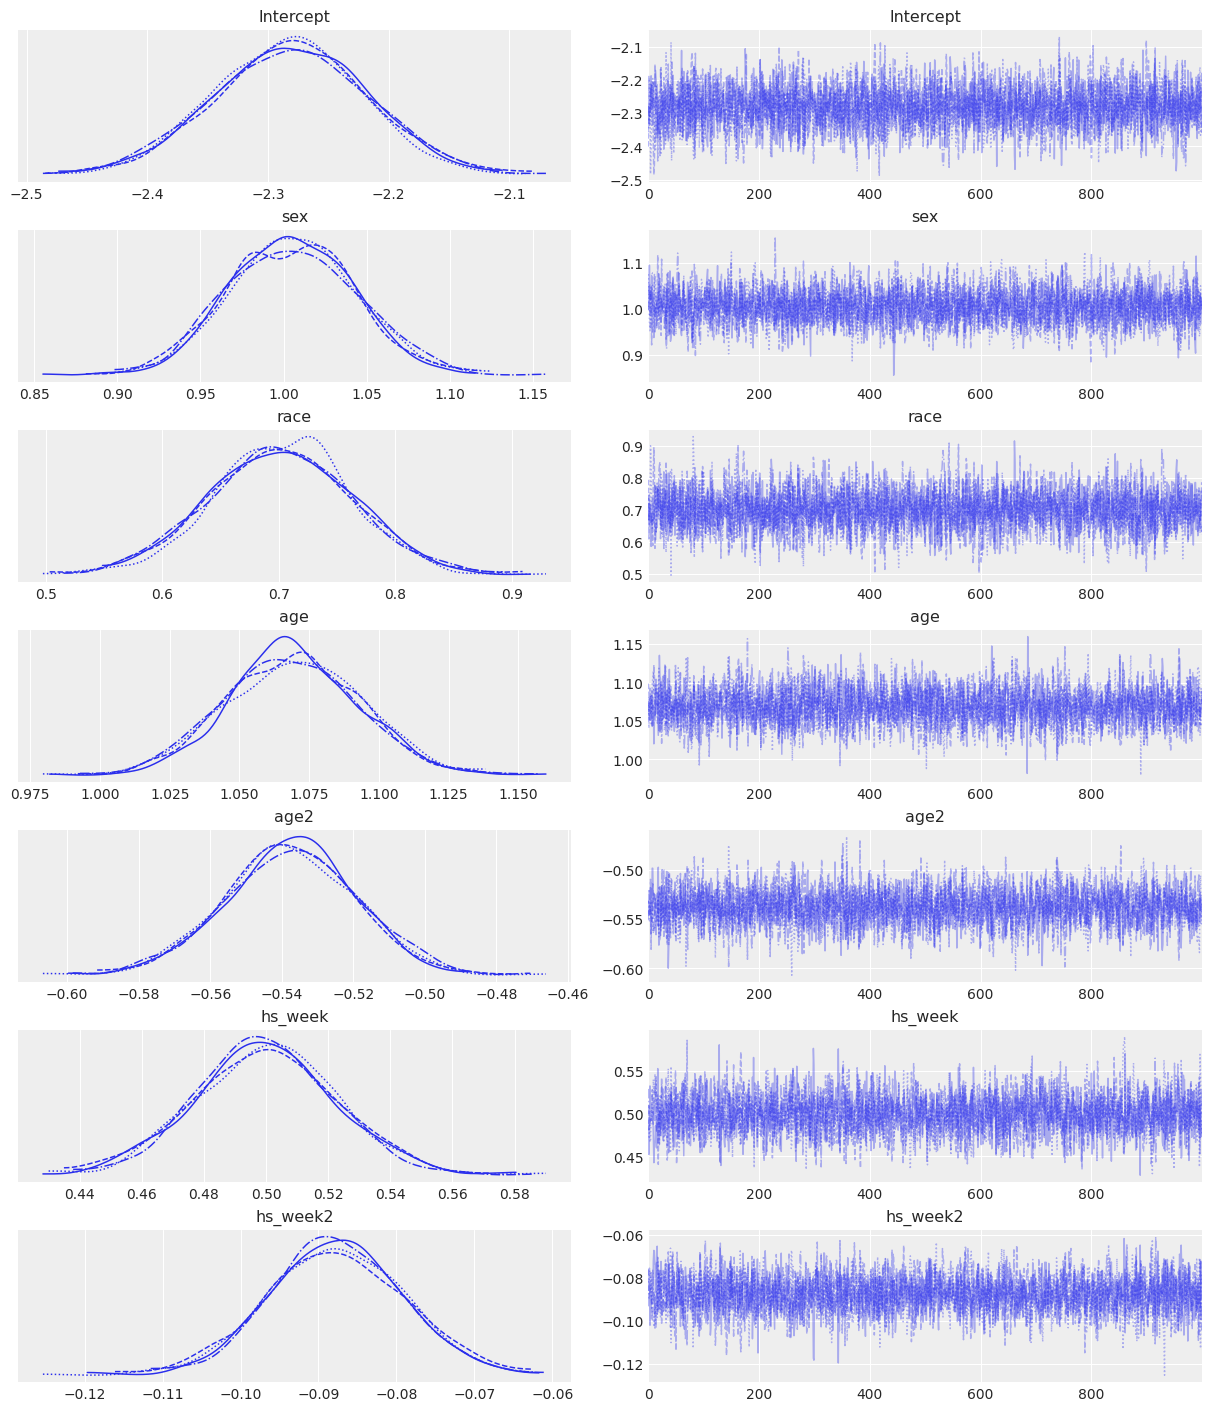

In [10]:
az.plot_trace(fitted2);
az.summary(fitted2)

## Model 3

In [11]:
model3 = bmb.Model(
    "income['>50K'] ~ age + age2 + age3 + hs_week + hs_week2 + hs_week3 + sex + race",
    data,
    family="bernoulli"
)
fitted3 = model3.fit(draws=1000)

Modeling the probability that income==>50K
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, age2, age3, hs_week, hs_week2, hs_week3, sex, race]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 274 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.145,0.067,-2.262,-2.016,0.001,0.001,4211.0,3086.0,1.0
age,0.964,0.026,0.912,1.010,0.000,0.000,3091.0,2605.0,1.0
age2,-0.894,0.031,-0.950,-0.835,0.001,0.000,2333.0,2274.0,1.0
age3,0.175,0.011,0.155,0.195,0.000,0.000,2819.0,2659.0,1.0
hs_week,0.613,0.025,0.562,0.655,0.000,0.000,3503.0,2947.0,1.0
hs_week2,-0.011,0.010,-0.030,0.009,0.000,0.000,3574.0,2525.0,1.0
hs_week3,-0.035,0.004,-0.042,-0.028,0.000,0.000,2876.0,2559.0,1.0
sex[Male],0.985,0.038,0.913,1.053,0.001,0.000,4432.0,3286.0,1.0
race[White],0.679,0.061,0.559,0.786,0.001,0.001,4080.0,2946.0,1.0


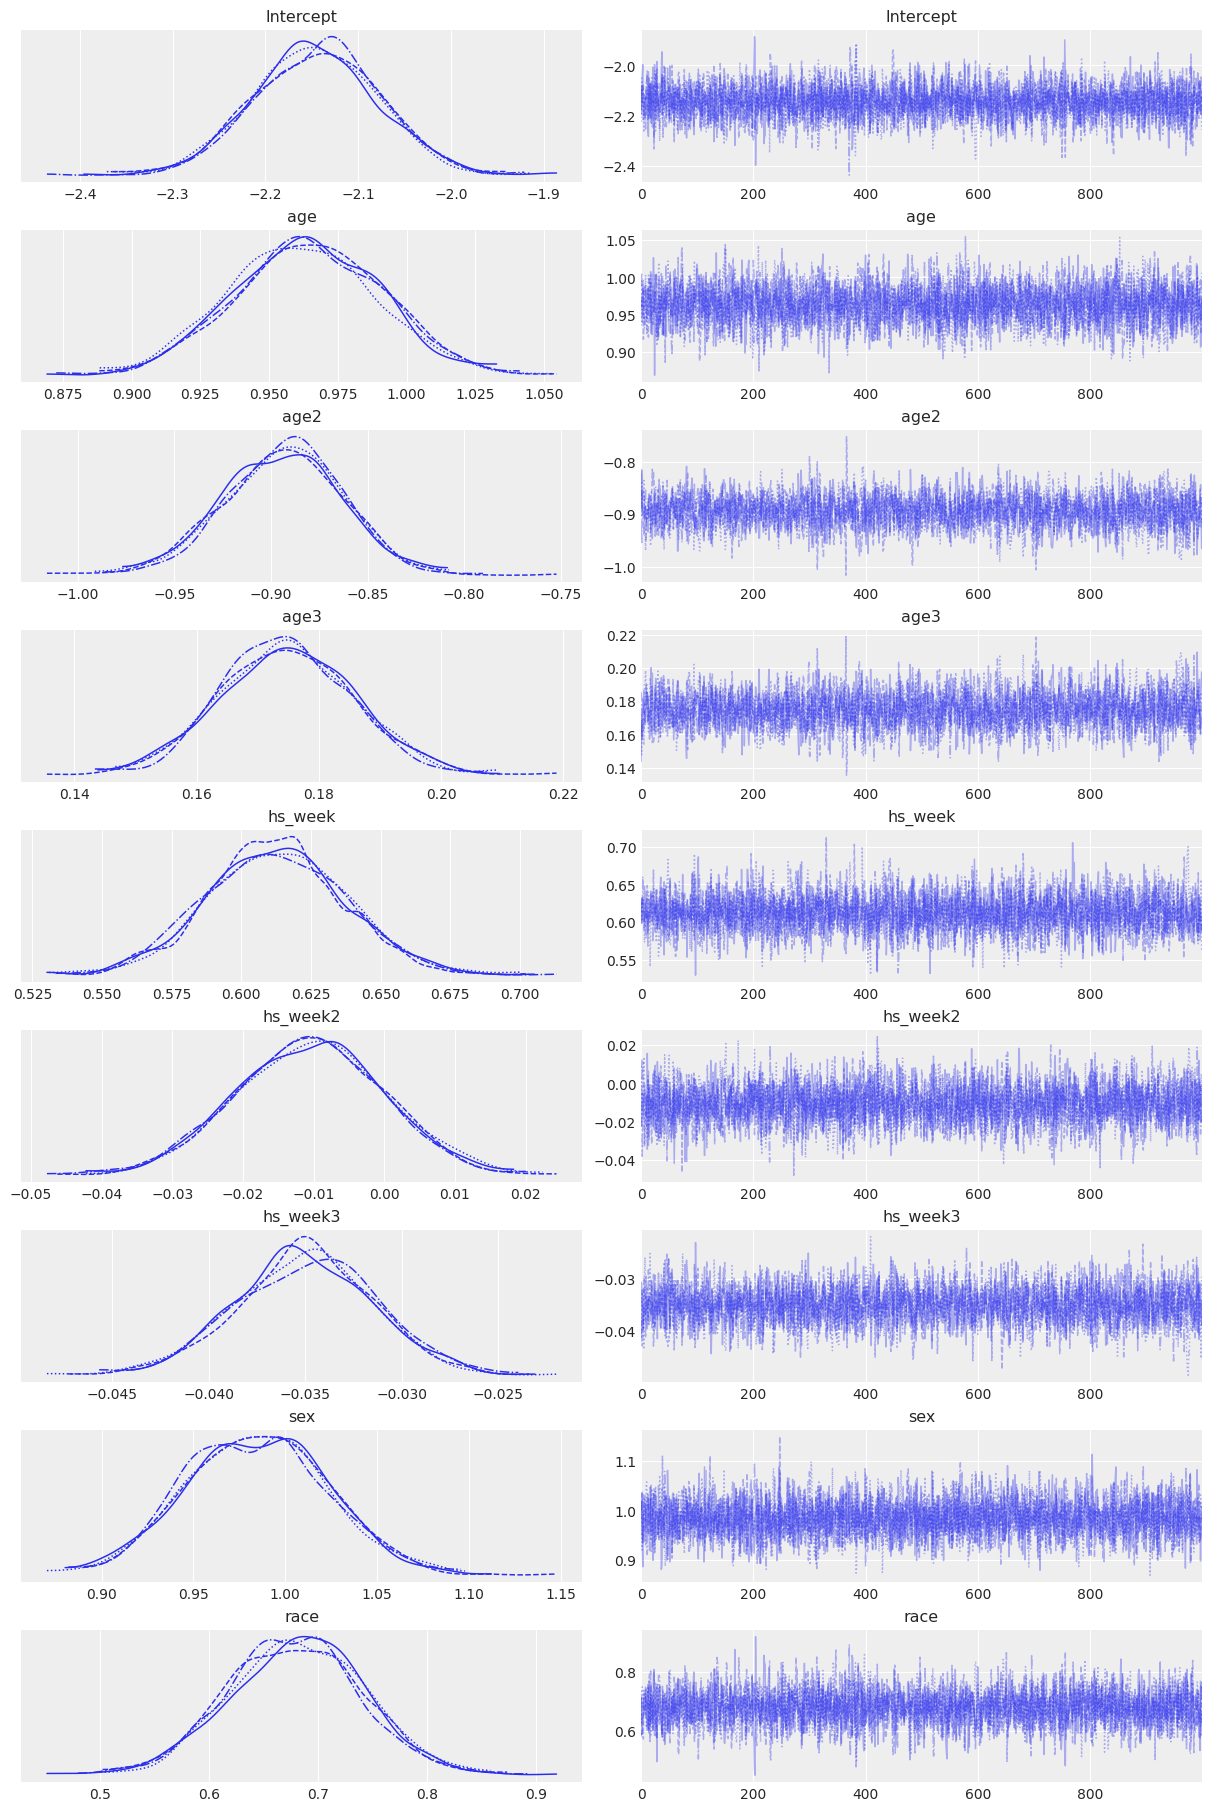

In [12]:
az.plot_trace(fitted3);
az.summary(fitted3)

# Model comparison

In [13]:
models_dict = {
    "model1": fitted1,
    "model2": fitted2,
    "model3": fitted3
}
df_compare = az.compare(models_dict)
df_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model3,0,-13987.293832,9.796443,0.000000,1.000000e+00,89.316854,0.000000,False,log
model2,1,-14155.052414,8.116998,167.758582,1.260109e-07,91.326923,19.882909,False,log
model1,2,-14915.994098,5.000947,928.700266,0.000000e+00,91.023226,38.914380,False,log


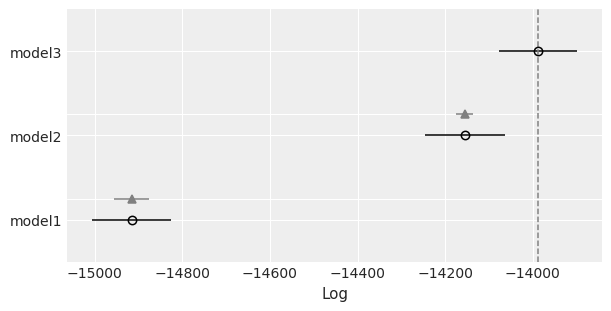

In [14]:
az.plot_compare(df_compare, insample_dev=False);

# Probability estimation

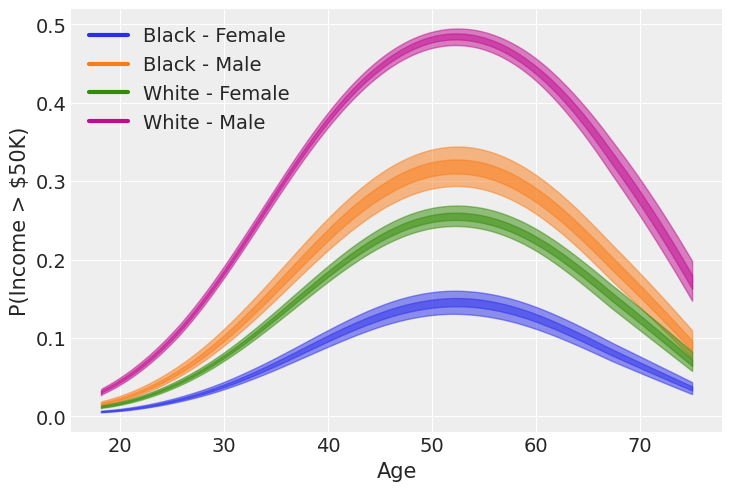

In [15]:
HS_WEEK = (40 - hs_mean) / hs_std
AGE = (np.linspace(18, 75) - age_mean) / age_std

fig, ax = plt.subplots()
handles = []
i = 0

for race in ["Black", "White"]:
    for sex in ["Female", "Male"]:
        color = f"C{i}"
        label = f"{race} - {sex}"
        handles.append(mlines.Line2D([], [], color=color, label=label, lw=3))

        new_data = pd.DataFrame({
            "sex": [sex] * len(AGE),
            "race": [race] * len(AGE),
            "age": AGE,
            "age2": AGE ** 2,
            "hs_week": [HS_WEEK] * len(AGE),
            "hs_week2": [HS_WEEK ** 2] * len(AGE),
        })
        new_idata = model2.predict(fitted2, data=new_data, inplace=False)
        mean = new_idata.posterior["income_mean"].values

        az.plot_hdi(AGE * age_std + age_mean, mean, ax=ax, color=color)
        az.plot_hdi(AGE * age_std + age_mean, mean, ax=ax, color=color, hdi_prob=0.5)
        i += 1

ax.set_xlabel("Age")
ax.set_ylabel("P(Income > $50K)")
ax.legend(handles=handles, loc="upper left");

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Aug 19 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

bambi     : 0.9.0
numpy     : 1.21.6
pandas    : 1.4.3
seaborn   : 0.11.2
matplotlib: 3.5.3
arviz     : 0.12.1

Watermark: 2.3.1

